# Viele Dateien

**Inhalt:** Massenverarbeitung von gescrapten Zeitreihen

**Nötige Skills:** Daten explorieren, Time+Date Basics

**Lernziele:**
- Pandas in Kombination mit Scraping
- Öffnen und zusammenfügen von vielen Dateien (Glob)
- Umstrukturierung von Dataframes (Pivot)
- Plotting Level 4 (Small Multiples)

## Das Beispiel

Wir interessieren uns in diesem Notebook für Krypto-Coins.

Die Webseite https://coinmarketcap.com/ führt Marktdaten zu den hundert wichtigsten Coins auf.

Mit einem einfachen Scraper werden wir diese Daten beschaffen.

Der Pfad zum Projektordner heisst `dataprojects/Krypto/`.

Zu jeder Kryptowährung haben wir ein csv-Datenfile im Unterordner `data/`.

## Vorbereitung

In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import re

In [4]:
import glob

In [5]:
%matplotlib inline

## Daten laden

**In diesem Teil hat es einige neue Funktionen drin, die wir noch nicht kennen. Sie können sich einfach durchklicken.**

### Einlesen 1: ein einzelnes File

Zu jeder Kryptowährung gibt es eine Datei mit den Kursdaten. Wir laden testweise eines davon:

In [6]:
path = 'dataprojects/Krypto/'

In [7]:
df = pd.read_csv(path + 'data/Bitcoin.csv')

In [8]:
df.head(2)

,date,open,high,low,close,volume,marketcap
0,"Oct 12, 2019",8315.66,8415.24,8313.34,8336.56,"14,532,641,605","149,965,767,624"
1,"Oct 11, 2019",8585.26,8721.78,8316.18,8321.76,"19,604,381,101","149,685,618,275"


Das DF ist 366 Einträge lang (da zu 365 + 1 Tagen Daten vorliegen)

In [9]:
len(df)

366

Theoretisch könnten wir diesen Code jetzt für jede der 100 Währungen manuell wiederholen.

Doch das ist umständlich, wir wollen automatisch alle Währungen laden.

### Einlesen 2: Alle Files auf einmal

**Schritt 1: Liste von Dateinamen erstellen**

Wir starten damit, dass wir das Verzeichnis durchsuchen, in dem alle Kryptowährungs-Daten abgelegt sind.

Dazu benutzen wir `glob`, ein praktisches Tool aus der Standard Library: https://docs.python.org/3/library/glob.html

In [10]:
filenames = glob.glob(path + 'data/*.csv')

In [11]:
len(filenames)

100

Wir haben nun eine Liste von allen Dateinamen. Die ersten zwei Einträge sind:

In [12]:
filenames[0:2]

['dataprojects/Krypto/data/BitCapitalVendor.csv',
 'dataprojects/Krypto/data/XMax.csv']

**Schritt 2: Liste von Dataframes anhand der Dateinamen**

Nun lesen wir jede einzelne Datei aus der Liste ein - und zwar in eine **Liste von Dataframes**.

Diese Liste nennen wir `dfs[]`. Sie wird 100 Einträge haben, jedes davon ein Dataframe.

In [13]:
dfs = []

Zum Einlesen benutzen wir list comprehension...

In [14]:
dfs = [pd.read_csv(filename) for filename in filenames]

In [15]:
dfs[0].head(2)

,date,open,high,low,close,volume,marketcap
0,"Oct 12, 2019",0.042286,0.043125,0.040426,0.040929,"1,173,745","36,475,731"
1,"Oct 11, 2019",0.043115,0.043170,0.040623,0.042298,"1,173,758","37,695,631"


**Schritt 3: Zu jedem Dataframe den Währungsnamen hinzufügen**

Die einzelnen Dataframes in der Liste enthalten die Marktdaten. Doch sie enthalten selbst keine Information darüber, zu welcher Kryptowährung die Daten gehören. Wir führen zu dem Zweck in jedes Dataframe noch eine zusätzliche Spalte hinzu mit dem Namen der Währung. 

Praktisch ist zu diesem Zweck die Python-Funktion `zip()`. Sie fügt zwei separate Listen – hier: die Dataframes und die Dateinamen – wie ein Reissverschluss zusammen, so dass wir gleich durch beide aufs Mal loopen können.

In [16]:
for df, filename in zip(dfs, filenames):
    df['currency'] = filename
    df['currency'] = df['currency'].str.extract('/data/(.+).csv')

In [17]:
dfs[0].head(2)

,date,open,high,low,close,volume,marketcap,currency
0,"Oct 12, 2019",0.042286,0.043125,0.040426,0.040929,"1,173,745","36,475,731",BitCapitalVendor
1,"Oct 11, 2019",0.043115,0.043170,0.040623,0.042298,"1,173,758","37,695,631",BitCapitalVendor


**Schritt 4: Die DFs untereinander in ein einziges DF reihen**

Nun fügen wir alle Dataframes zu einem einzigen, sehr langen Dataframe zusammen.

Dazu benutzen wir die Funktion `pd.concat()`: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.concat.html

In [18]:
df_all = pd.concat(dfs, ignore_index=True)

Das resultierende DF ist nun 100x länger als die einzelnen zuvor:

In [19]:
df_all.shape

(34567, 8)

In [20]:
df_all.head(2)

,date,open,high,low,close,volume,marketcap,currency
0,"Oct 12, 2019",0.042286,0.043125,0.040426,0.040929,"1,173,745","36,475,731",BitCapitalVendor
1,"Oct 11, 2019",0.043115,0.043170,0.040623,0.042298,"1,173,758","37,695,631",BitCapitalVendor


In [21]:
df_all.tail(2)

,date,open,high,low,close,volume,marketcap,currency
34565,"Oct 13, 2018",0.174794,0.177004,0.173345,0.176677,"3,610,690","177,118,564",Bytom
34566,"Oct 12, 2018",0.167734,0.177526,0.165599,0.174445,"19,126,300","174,880,986",Bytom


In [22]:
df_all.dtypes

date          object
open         float64
high         float64
low          float64
close        float64
volume        object
marketcap     object
currency      object
dtype: object

Wir haben nun ein ellenlanges Dataframe. What next?

### Daten arrangieren

Das hängt davon ab, was wir mit den Daten genau tun wollen.

Eine Option wäre: die verschiedenen Währungen miteinander zu vergleichen. Und zwar anhand der Schlusskurse.

Dazu müssen wir das Dataframe leicht umstellen, mit `pivot()`: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.pivot.html

In [23]:
df_pivoted = df_all.pivot(index='date', columns='currency', values='close')

Mit `pivot()` haben wir folgendes gemacht:
- Statt im "Long"-Format sind die Daten nun im "Wide"-Format
- Das heisst in diesem Fall: Wir haben es anhand der Währungen rearrangiert (`columns='currency'`)
- Die Währungen stehen jetzt nicht mehr *untereinander*, sondern *nebeneinander*
- Die Info, die wir für jede Währung ausgewählt haben, ist der Schlusskurs `values='Close'`)
- Das DF ist jetzt wieder nur noch 366 Zeilen lang.
- Index jeder Zeile ist ein Datum (`index='date'`)

In [24]:
df_pivoted.shape

(366, 100)

Nun verfügen wir über einen Index, bei dem eine Zeile jeweils einem einzigartigen Zeitpunkt entspricht.

Wir verschönern die Indexspalte noch etwas:

In [25]:
df_pivoted.rename_axis(None, inplace=True)

In [26]:
df_pivoted.head(2)

currency,0x,ABBC Coin,Aeternity,Algorand,Ardor,Augur,Aurora,Basic Attenti...,Binance Coin,BitCapitalVendor,...,VeChain,Verge,Waves,XMax,XRP,ZB,Zcash,Zcoin,Zilliqa,aelf
"Apr 01, 2019",0.333060,0.174615,0.535463,NaN,0.082073,15.81,0.013118,0.284441,17.95,0.020534,...,0.006285,0.007409,2.89,0.000213,0.312747,0.356519,62.42,7.80,0.020646,0.186018
"Apr 02, 2019",0.376557,0.187213,0.588288,NaN,0.087155,17.62,0.014222,0.321107,19.79,0.020990,...,0.007243,0.008337,3.09,0.000262,0.351499,0.340334,69.94,8.27,0.022510,0.197836


Wir haben nun ein sauber formatiertes Dataframe mit hundert Spalten, die für jede Kryptowährung, sofern sie zum betreffenden Zeitpunkt existierte, einen Handelskurs enthält.

**Grossartig! Wir sind damit bereit für die Datenanalyse. Ab hier sind Sie an der Reihe...**

## Analyse

### Vorbereitung

Remember: Mit welchem Typ von Daten haben wir es hier zu tun...?

... genau: mit einer Zeitreihe.

Um damit zu arbeiten, müssen wir den Text in der Indexspalte in ein echtes Datum umwandeln.

In [27]:
df_pivoted.index = pd.to_datetime(df_pivoted.index, format="%b %d, %Y")

Und wir müssen den Datums-Index aufsteigend sortieren.

In [28]:
df_pivoted.sort_index(inplace=True)

In [29]:
df_pivoted.head(2)

currency,0x,ABBC Coin,Aeternity,Algorand,Ardor,Augur,Aurora,Basic Attenti...,Binance Coin,BitCapitalVendor,...,VeChain,Verge,Waves,XMax,XRP,ZB,Zcash,Zcoin,Zilliqa,aelf
2018-10-12,0.742107,0.371426,1.12,NaN,0.111454,11.79,0.020980,0.178842,9.53,0.003599,...,0.011562,0.014124,1.88,0.000288,0.419115,0.223905,109.02,9.06,0.032146,0.315603
2018-10-13,0.732961,0.375956,1.11,NaN,0.113054,12.46,0.021105,0.176788,9.54,0.003756,...,0.011481,0.014084,1.89,0.000287,0.418878,0.227764,111.57,8.94,0.032902,0.310652


Die nächste Frage ist: Wie vergleichen wir diese Kurse? Was sagt es aus, wenn eine Währung an einem bestimmten Tag zu 0,1976 USD gehandelt wurde und eine andere zu 18,66 USD?

### Vergleichbarkeit herstellen

Diverse Dinge würden sich hier anbieten:
- zB `pct_change()` um die Veränderungen in den Kursen zu analysieren
- oder eine indexierte Zeitreihe, die an einem bestimmten Tag bei 100 beginnt

Wir wählen die zweite Variante. Und speichern dazu die erste Zeile separat ab.

In [30]:
row_0 = df_pivoted.iloc[0]

Dann teilen wir jede einzelne Zeile im Dataframe durch die erste Zeile. Und speichern als neues DF ab.

In [31]:
df_pivoted_100 = df_pivoted / row_0 * 100

Das neue Dataframe müsste nun indexiert auf 100 sein: Alle Währungen starten am gleichen Punkt.

Stimmt das wirklich? Schauen Sie sich die ersten fünf Zeilen an, um sicher zu sein...

In [32]:
df_pivoted_100.head(5)

currency,0x,ABBC Coin,Aeternity,Algorand,Ardor,Augur,Aurora,Basic Attenti...,Binance Coin,BitCapitalVendor,...,VeChain,Verge,Waves,XMax,XRP,ZB,Zcash,Zcoin,Zilliqa,aelf
2018-10-12,100.000000,100.000000,100.000000,NaN,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2018-10-13,98.767563,101.219624,99.107143,NaN,101.435570,105.682782,100.595806,98.851500,100.104932,104.362323,...,99.299429,99.716794,100.531915,99.652778,99.943452,101.723499,102.339020,98.675497,102.351770,98.431257
2018-10-14,95.696308,97.771831,101.785714,NaN,100.925943,102.205259,96.982841,96.368303,99.685205,94.665185,...,98.252897,98.739734,100.531915,109.722222,96.223232,100.473862,99.559714,100.441501,101.782492,100.878002
2018-10-15,98.085451,97.361251,105.357143,NaN,103.104420,104.240882,123.651096,101.811655,108.289612,89.636010,...,101.911434,103.186066,106.914894,102.777778,106.728702,103.593488,103.577325,104.635762,106.753562,105.487907
2018-10-16,114.957277,157.654553,106.250000,NaN,103.333214,107.209500,124.933270,105.026224,105.036726,91.330925,...,102.464971,101.338148,106.914894,104.166667,112.201424,102.857908,105.870482,109.492274,106.961986,104.689753


### Auswertung

Anhand der letzten Reihe können wir ablesen, wie viel eine Währung in den 366 Tagen an Wert gewonnen oder verloren hat.

Zeigen Sie die letzte Reihe an und speichern sie in einer neuen Series.

In [33]:
s_last = df_pivoted_100.iloc[-1]

Welche zehn Kryptowährungen haben am meisten Wert gewonnen?

In [34]:
s_last.sort_values(ascending=False).head(10)

currency
BitCapitalVendor    1137.232565
EDUCare             1077.792675
Chainlink            838.478787
Energi               836.830941
XMax                 695.138889
Quant                570.873786
Seele                341.578658
Synthetix Net...     310.490345
Centrality           276.869190
Ren                  237.726853
Name: 2019-10-12 00:00:00, dtype: float64

Welche haben am meisten Wert verloren?

In [35]:
s_last.sort_values(ascending=False, na_position='first').tail(10)

currency
ICON           27.567398
Verge          26.168224
Stratis        25.533609
aelf           24.285574
Dentacoin      23.893805
Zilliqa        18.027126
Electroneum    17.229022
Steem          16.561069
Aeternity      15.592589
Pundi X        14.209115
Name: 2019-10-12 00:00:00, dtype: float64

### Plots

Erstellen Sie einen einfachen Linienplot mit den relativen Kursen aller Währungen (Start bei 100).

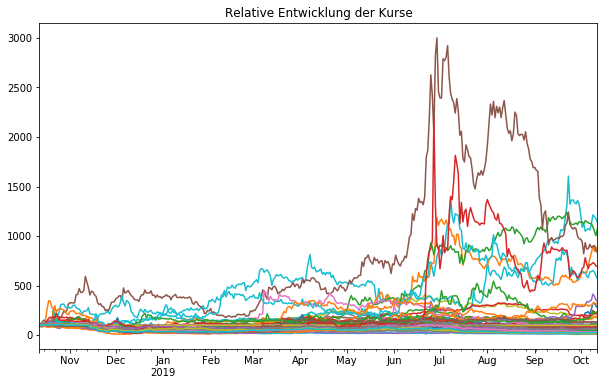

In [36]:
df_pivoted_100.plot(figsize=(10,6), legend=False, title='Relative Entwicklung der Kurse')

Wow, das sind ziemlich viele Linien! Beschränken wir uns mal auf zehn Kryptowährungen statt hundert.

Wir finden dazu eine Liste, die wir praktischerweise von unserem Scraper noch auf die Seite gelegt haben...

... sie ist gespeichert unter: `dataprojects/Krypto/currencies.csv`.

Laden Sie die Datei und zeigen Sie die ersten zehn Zeilen an.

In [37]:
df_currencies = pd.read_csv(path + 'currencies.csv')

In [38]:
df_currencies.head(10)

,name,link
0,Bitcoin,bitcoin
1,Ethereum,ethereum
2,XRP,ripple
3,Tether,tether
4,Bitcoin Cash,bitcoin-cash
5,Litecoin,litecoin
6,EOS,eos
7,Binance Coin,binance-coin
8,Bitcoin SV,bitcoin-sv
9,Stellar,stellar


Speichern Sie die ersten zehn Einträge der Spalte "name" separat ab.

In [39]:
names_10 = df_currencies['name'].head(10)

In [40]:
names_10

0         Bitcoin
1        Ethereum
2             XRP
3          Tether
4    Bitcoin Cash
5        Litecoin
6             EOS
7    Binance Coin
8      Bitcoin SV
9         Stellar
Name: name, dtype: object

Sie können die Spalten im Dataframe mit den relativen Kursen nun anhand dieser Liste filtern.

In [41]:
df_pivoted_100[names_10]

currency,Bitcoin,Ethereum,XRP,Tether,Bitcoin Cash,Litecoin,EOS,Binance Coin,Bitcoin SV,Stellar
2018-10-12,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,100.000000
2018-10-13,100.181845,101.580847,99.943452,99.390807,101.168693,99.813259,101.351351,100.104932,NaN,99.434343
2018-10-14,100.260575,99.486606,96.223232,99.544111,99.097534,97.460317,99.806950,99.685205,NaN,97.274478
2018-10-15,105.131180,106.592792,106.728702,98.595315,103.643706,102.483660,105.598456,108.289612,NaN,103.225911
2018-10-16,105.124327,106.806283,112.201424,98.093757,103.334612,100.971055,105.019305,105.036726,NaN,105.529736
...,...,...,...,...,...,...,...,...,...,...
2019-10-08,131.144714,92.522747,66.439760,101.599232,52.424249,107.189542,61.389961,169.045121,NaN,28.646682
2019-10-09,136.993074,98.251411,67.195638,101.599232,54.021614,110.980392,62.741313,186.883526,NaN,29.326674
2019-10-10,136.845335,97.422864,64.916073,100.593299,51.916612,107.899160,61.003861,184.365163,NaN,28.674456
2019-10-11,132.626566,92.802318,64.683679,101.599232,50.219976,105.135387,60.617761,175.341028,NaN,28.153699


Plotten Sie nun ausschliesslich die Entwicklung der zehn ausgewählten Währungen.

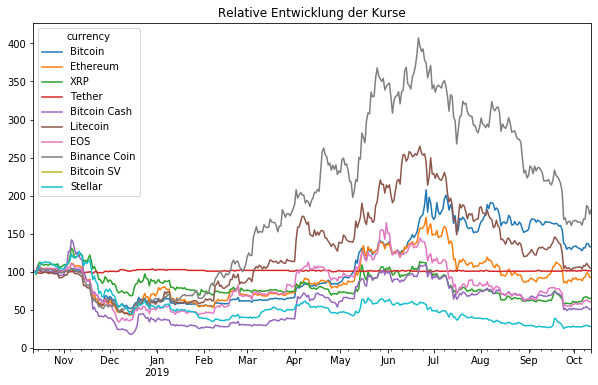

In [42]:
df_pivoted_100[names_10].plot(figsize=(10,6), legend=True, title='Relative Entwicklung der Kurse')

Was fällt Ihnen auf?

In [43]:
# Die Kurse bewegen sich ziemlich synchron. Es scheint also Faktoren zu geben, die sich auf alle Kryptowäührungen auswirken.
# Eine Währung (Tether) hat immer den Wert 100. (Das ist, weil sie an den Dollar gebunden ist)

# Plotting Level 4

**Hier geht es wieder gemütlicher zu und her - Sie können sich durchklicken und müssen nichts programmieren.**

Inhalt dieser Plotting-Lektion:

- Wir lernen, wie "Small Multiples" geht
- Wir sehen, wie man die matplotlib-Funktionen direkt benutzen kann.

Dazu importieren wir erstmal ein paar Libraries...

In [44]:
import matplotlib.pyplot as plt

In [45]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

... und laden eine Datei, welche das Ergebnis der bisherigen Übung enthält (die relativen Kurse aller Währungen).

In [46]:
# df_pivoted_100.to_csv(path + 'Close_indexed_to_100.csv')

In [47]:
df_relative = pd.read_csv(path + 'Close_indexed_to_100.csv', index_col=0)
df_relative.index = pd.to_datetime(df_relative.index)

### Ein Plot

Starten wir zuerst mal mit einem Plots: Bitcoin.

Technisch gesehen besteht jede Matplotlib-/Pandas-Grafik aus zwei Dingen:
1. Eine "figure", also eine Abbildung, gewissermassen das Blatt Papier
1. Ein "subplot", also der einzelne Plot selbst, pro "Papier" können es auch mehrere sein

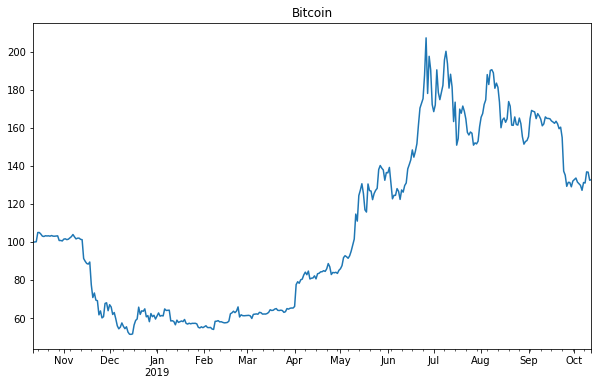

In [48]:
# Wir erstellen beide Dinge in einem Atemzug: figure und subplot
fig, ax = plt.subplots(figsize=(10,6))

# Und füllen den Plot jetzt mit Inhalt:
df_relative['Bitcoin'].plot(title="Bitcoin", ax=ax)

### Zwei Plots

Als nächstes Plotten wir zwei Währungen auf derselben Figure: Bitcoin und Ethereum.

Wir müssen uns dazu erneut zwei Dinge basteln:
1. Eine "figure", also eine Abbildung
1. Diverse "subplots" für die jeweiligen Währungen

Dazu formatieren wir jetzt die x-Achse etwas speziell.

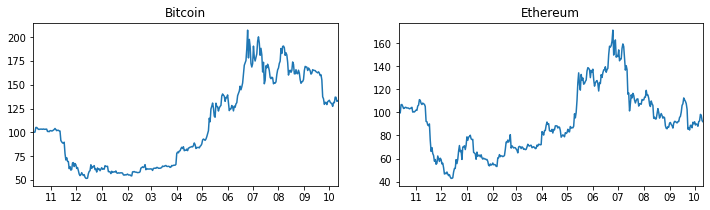

In [49]:
# Zuerst kreieren wir nur die Figure
fig = plt.figure(figsize=(12,3))

# Danach die einzelnen Subplots
ax1 = fig.add_subplot(1, 2, 1) # total 1 Zeile, total 2 Spalten, Subplot Nr. 1
ax2 = fig.add_subplot(1, 2, 2) # total 1 Zeile, total 2 Spalten, Subplot Nr. 2

# Und schliesslich füllen wir die Subplots mit Inhalt
df_relative['Bitcoin'].plot(title="Bitcoin", ax=ax1)
df_relative['Ethereum'].plot(title="Ethereum", ax=ax2)

# Hier formatieren wir die x-Achse für Plot 1
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
ax1.xaxis.set_minor_locator(ticker.NullLocator())

# Hier formatieren wir die x-Achse für Plot 2
ax2.xaxis.set_major_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
ax2.xaxis.set_minor_locator(ticker.NullLocator())

Einige Angaben dazu, wie man Zeitachsen formatieren kann, gibt es hier:
- TickLocators: https://matplotlib.org/examples/ticks_and_spines/tick-locators.html
- TickFormatters: https://matplotlib.org/gallery/ticks_and_spines/tick-formatters.html

### Sehr viele Plots

Nun plotten wir sämtliche Währungen, die keine "NaN"-Werte enthalten, auf einmal.

Dazu isolieren wir erst kurz die letzte Zeile.

In [50]:
s_last = df_relative.iloc[-1]

Wie viele Währungen sind nicht "NaN"?

In [51]:
anzahl_charts = s_last.notnull().sum()
anzahl_charts

87

Wir sortieren unsere Liste der Währungen anhand der letzten Zeile etwas:

In [52]:
sortierte_waehrungen = s_last[s_last.notnull()].sort_values(ascending=False)
sortierte_waehrungen.head(2)

BitCapitalVendor    1137.232565
EDUCare             1077.792675
Name: 2019-10-12 00:00:00, dtype: float64

Und wiederholen dann wiederum dasselbe Vorgehen wie vorher.

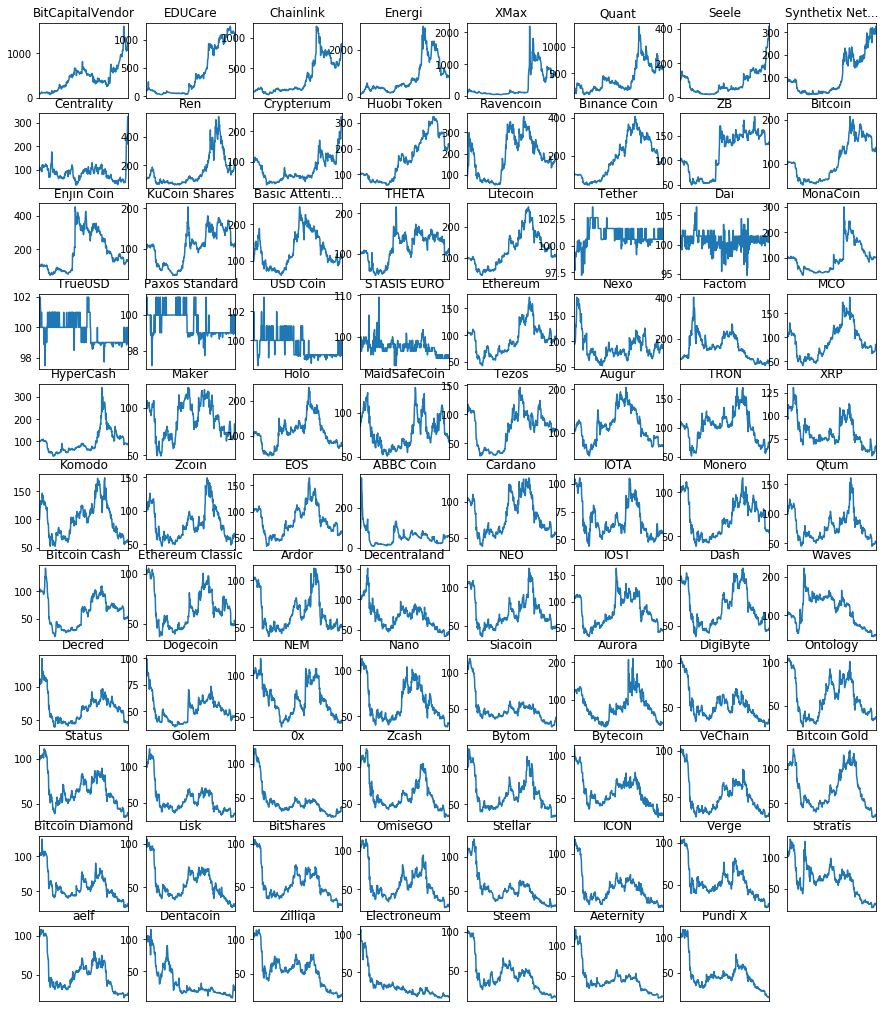

In [53]:
# Eine Abbildung, die gross genug ist
fig = plt.figure(figsize=(15,18))

# Und nun, für jede einzelne Währung einen Subplot:
for i, waehrung in enumerate(sortierte_waehrungen.index):
    
    # einen Subplot kreieren ... ()
    ax = fig.add_subplot(11, 8, i + 1)

    # ... und mit Inhalt füllen
    df_pivoted_100[waehrung].plot(title=waehrung, ax=ax)
    
    # Auf Ticks verzichten wir hier ganz
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.xaxis.set_minor_locator(ticker.NullLocator())

Falls wir zusätzlich noch wollen, dass jeder Plot dieselbe y-Achse hat:

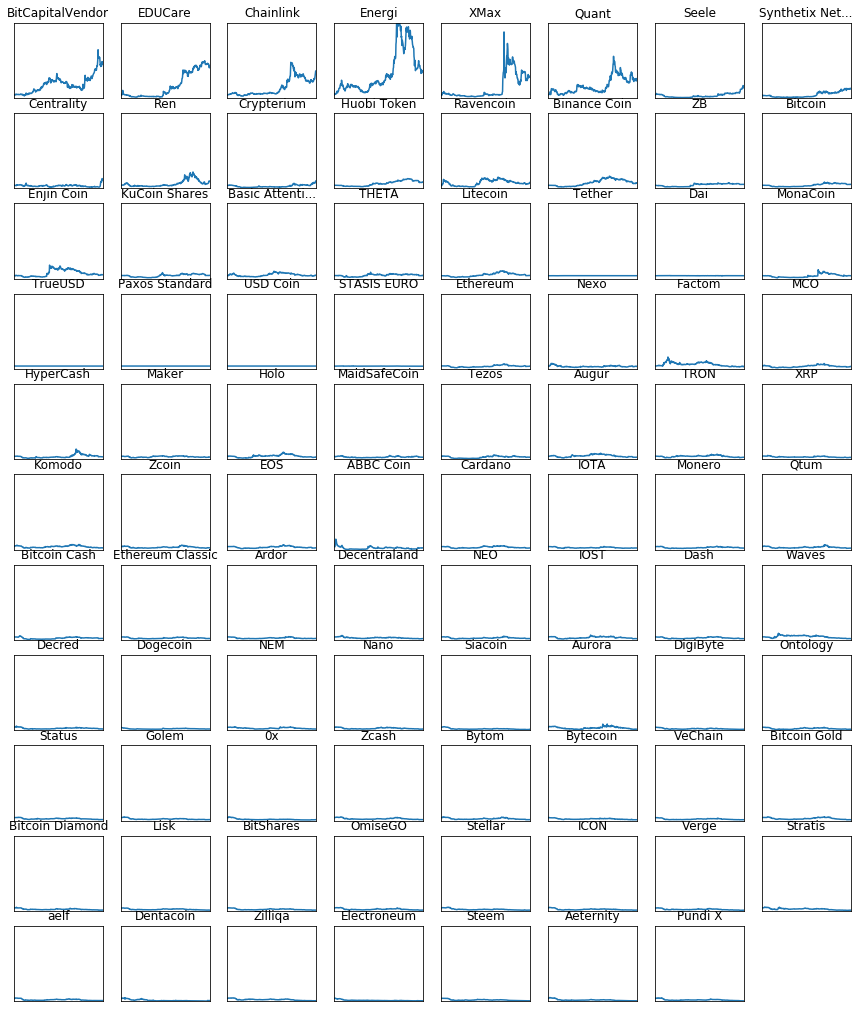

In [54]:
# Eine Abbildung, die gross genug ist
fig = plt.figure(figsize=(15,18))

# Und nun, für jede einzelne Währung:
for i, waehrung in enumerate(sortierte_waehrungen.index):
    
    # einen Subplot kreieren ...
    ax = fig.add_subplot(11, 8, i + 1)

    # ... und mit Inhalt füllen
    df_pivoted_100[waehrung].plot(title=waehrung, ax=ax)
    
    # Auf Ticks verzichten wir hier ganz
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    
    # Hier setzen wir eine einheitliche y-Achse (und schalten sie aus)
    ax.set_ylim([0, 2500])
    ax.yaxis.set_major_locator(ticker.NullLocator())

### Aber es geht auch einfacher...

Ha! Nachdem wir nun alles Manuell zusammengebastelt haben, mit Matplotlib, hier die gute Nachricht:

*Wir können das mit wenigen Codezeilen auch direkt aus der Pandas-Plot()-Funktion haben :-)*

Die entscheidenden Parameter in der `plot()`-Funktion sind hier:
- `subplots=True` (zeichnet small multiples statt alles nur auf einem Chart)
- `sharey=True` (alle Subplots sollen dieselbe y-Achse verwenden)

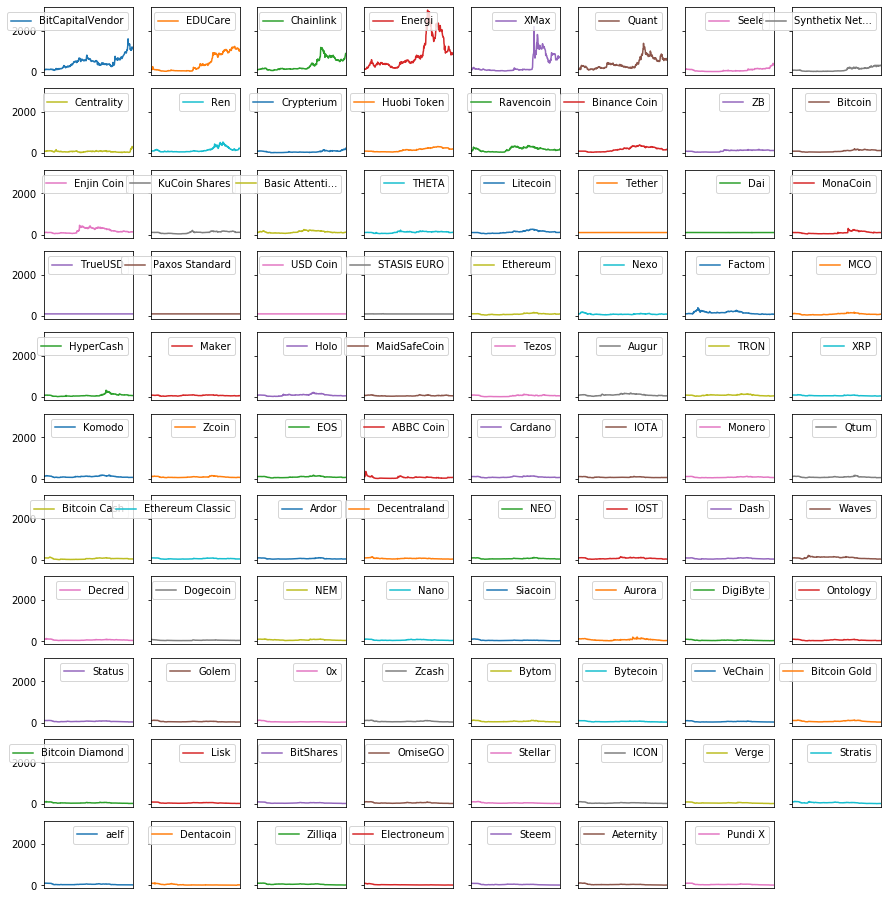

In [55]:
axes = df_pivoted_100[sortierte_waehrungen.index].plot(subplots=True,layout=(11, 8), sharey=True, figsize=(15,18))

axes[0,0].xaxis.set_major_locator(ticker.NullLocator())
axes[0,0].xaxis.set_minor_locator(ticker.NullLocator())

# Übung

**In dieser letzten Sektion haben Sie nochmals Gelegenheit, alles zu üben – Daten arrangieren, analysieren, plotten**

Hier schauen wir uns nicht mehr die Handelskurse, sondern die Handelsvolumen an! Also: Wie viel von den einzelnen Kryptowährungen an einem bestimmten Tag gekfauft und verkauft wurde (gemessen in USD).

Schauen Sie sich nochmals das Dataframe `df_all` an, das wir im Verlauf des Notebooks erstellt haben - es enthält alle Informationen, die wir brauchen, ist aber noch relativ unstrukturiert.

In [56]:
df_all.head(2)

,date,open,high,low,close,volume,marketcap,currency
0,"Oct 12, 2019",0.042286,0.043125,0.040426,0.040929,"1,173,745","36,475,731",BitCapitalVendor
1,"Oct 11, 2019",0.043115,0.043170,0.040623,0.042298,"1,173,758","37,695,631",BitCapitalVendor


Welche Spalte interessiert uns? Müssen wir noch etwas daran machen?

### Daten arrangieren

Unternehmen Sie die nötigen Schritte, um mit der Spalte arbeiten zu können. Sie sollten am Ende eine Spalte haben, die nicht mehr als Object, sondern als Float formatiert ist.

Tipp: Speichern Sie alle Modifikationen in einer neuen Spalte ab, damit das Original unverändert bleibt.

In [57]:
df_all['volume_corr'] = df_all['volume'].str.replace(r"[,-]", "")

In [58]:
df_all['volume_corr'] = df_all['volume_corr'].replace("", np.nan)

In [59]:
df_all['volume_corr'] = df_all['volume_corr'].astype(float)

Nun wollen wir die Daten umgliedern:
- Für jedes Datum wollen wir eine Zeile
- Für jede Kryptowährung eine Spalte
- Wir interessieren uns für die Handelsvolumen

In [60]:
df_pivoted2 = df_all.pivot(index='date', columns='currency', values='volume_corr')

In [61]:
df_pivoted2.head(2)

currency,0x,ABBC Coin,Aeternity,Algorand,Ardor,Augur,Aurora,Basic Attenti...,Binance Coin,BitCapitalVendor,...,VeChain,Verge,Waves,XMax,XRP,ZB,Zcash,Zcoin,Zilliqa,aelf
date,,,,,,,,,,,,,,,,,,,,,
"Apr 01, 2019",24212475.0,31254990.0,38071057.0,NaN,1258247.0,6008447.0,2036125.0,33115370.0,202977286.0,65780.0,...,16899764.0,6326265.0,13674082.0,128032.0,8.361232e+08,54066789.0,189443569.0,1422393.0,14800033.0,11626054.0
"Apr 02, 2019",38696273.0,44735893.0,45202852.0,NaN,2193845.0,13041345.0,2234374.0,37763598.0,264406306.0,143544.0,...,33542819.0,10730078.0,25124077.0,171737.0,2.400198e+09,18774494.0,466924123.0,2235720.0,28538698.0,18456425.0


Formatieren Sie die Werte in der Index-Spalte als Datetime-Objekte und sortieren Sie das Dataframe nach Datum.

In [62]:
df_pivoted2.rename_axis(None, inplace=True)

In [63]:
df_pivoted2.index = pd.to_datetime(df_pivoted.index, format="%b %d, %Y")

In [64]:
df_pivoted2.sort_index(inplace=True)

### Analyse

Wir machen in dieser Sektion einige einfache Auswertungen und repetieren einige Befehle, u.a. aus dem Time Series Sheet.

**Top-10**: Welches waren, im Schnitt, die zehn meistgehandelten Währungen? Liste und Chart.

In [65]:
df_pivoted2.mean().sort_values(ascending=False).head(10)

currency
Bitcoin             1.308526e+10
Tether              1.270178e+10
Ethereum            5.568209e+09
Litecoin            2.186710e+09
EOS                 1.658168e+09
Bitcoin Cash        1.103178e+09
XRP                 1.063251e+09
TRON                4.200638e+08
Ethereum Classic    4.078776e+08
NEO                 2.858348e+08
dtype: float64

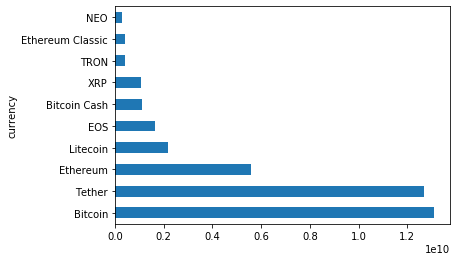

In [66]:
df_pivoted2.mean().sort_values(ascending=False).head(10).plot(kind='barh')

Welches waren die zehn Währungen, bei denen das Volumen in absoluten Zahlen am meisten geschwankt ist? (Standardabweichung)

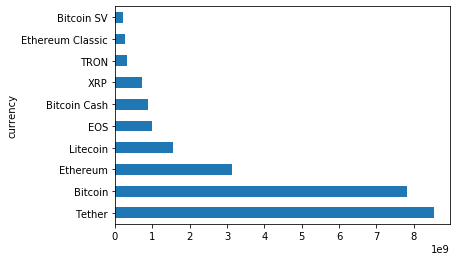

In [67]:
df_pivoted2.std().sort_values(ascending=False).head(10).plot(kind='barh')

Sieht so aus, als wären es dieselben zehn Währungen.

Können wir angeben, welche von ihnen relativ die grössten Schwankungen hatten, also im Vergleich zum Handelsvolumen?

In [68]:
top_10 = df_pivoted2.mean().sort_values(ascending=False).head(10).index

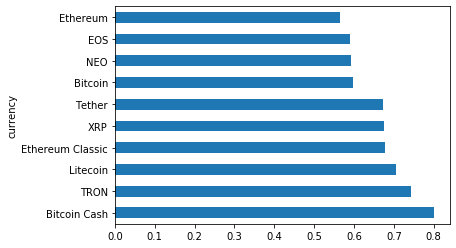

In [69]:
(df_pivoted2[top_10].std() / df_pivoted2[top_10].mean()).sort_values(ascending=False).plot(kind='barh')

**Bitcoin vs Ethereum**

Erstellen Sie einen Chart mit dem wöchentlichen Umsatztotal von Bitcoin und Ethereum!

Tipp: Resampling benutzen!

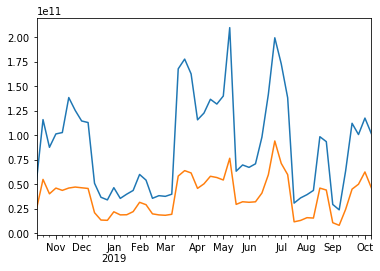

In [70]:
df_pivoted2['Bitcoin'].resample('W').sum().plot()
df_pivoted2['Ethereum'].resample('W').sum().plot()

In welchem der letzten 12 Monate wurde insgesamt am meisten mit Bitcoin gehandelt? Mit Ethereum?

In [71]:
df_pivoted2['Bitcoin'].resample('MS').sum().sort_values(ascending=False).head(1)

2019-03-01    5.641155e+11
Name: Bitcoin, dtype: float64

In [72]:
df_pivoted2['Ethereum'].resample('MS').sum().sort_values(ascending=False).head(1)

2019-06-01    2.370170e+11
Name: Ethereum, dtype: float64

Wie viel Bitcoin und Ethereum wird im Durchschnitt an den sieben Wochentagen gehandelt? Barchart.

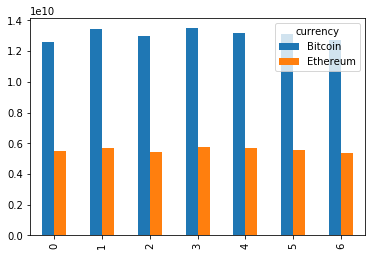

In [73]:
df_pivoted2[['Bitcoin', 'Ethereum']].groupby(df_pivoted2.index.weekday).mean().plot(kind='bar')

**Small Multiples**: Hier erstellen wir einen Plot, ähnlich wie oben

Kreieren Sie zuerst eine Liste von Währungen:
- Alle Währungen, die am letzten Handelstag einen Eintrag haben
- Sortiert in absteigender Reihenfolge nach dem Handelsvolumen
- Wir wählen nur die zehn grössten aus

In [74]:
sortierte_waehrungen = df_pivoted2.iloc[-1].sort_values(ascending=False).head(10)

In [75]:
len(sortierte_waehrungen)

10

In [76]:
sortierte_waehrungen

currency
Tether              2.110059e+10
Bitcoin             1.711547e+10
Ethereum            7.552915e+09
Litecoin            2.241249e+09
EOS                 1.771759e+09
XRP                 1.662002e+09
Bitcoin Cash        1.646589e+09
TRON                6.633591e+08
Ethereum Classic    5.363265e+08
TrueUSD             3.649075e+08
Name: 2019-10-12 00:00:00, dtype: float64

Und jetzt: Small Multiples plotten! Überlegen Sie sich:
- Wie viele Subplots braucht es, wie sollen sie angeordnet sein?
- Wie gross muss die Abbildung insgesamt sein?
- Was ist eine sinnvolle Einstellung für die Y-Achse?

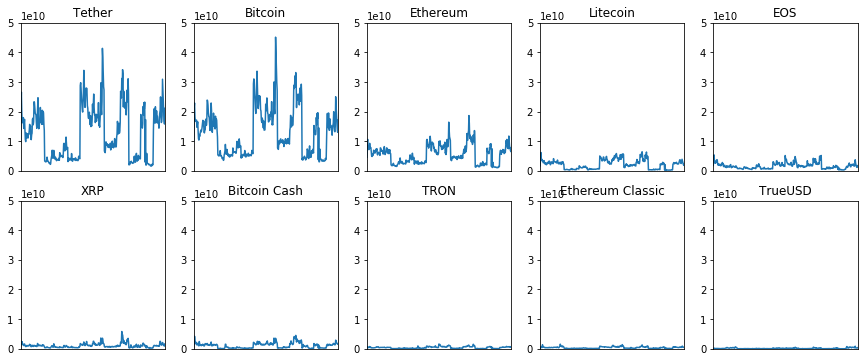

In [77]:
# Eine Abbildung, die gross genug ist
fig = plt.figure(figsize=(15,6))

# Und nun, für jede einzelne Währung:
for i, waehrung in enumerate(sortierte_waehrungen.index):
    
    # einen Subplot kreieren ...
    ax = fig.add_subplot(2, 5, i + 1)

    # ... und mit Inhalt füllen
    df_pivoted2[waehrung].plot(title=waehrung, ax=ax)
    
    # Auf Ticks verzichten wir hier ganz
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.xaxis.set_minor_locator(ticker.NullLocator())
    
    ax.set_ylim([0, 5e10])

Alternative syntax dafür:

(0, 50000000000.0)

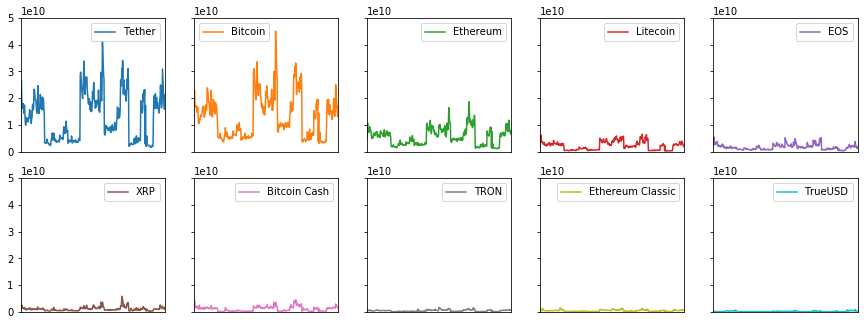

In [78]:
axes = df_pivoted2[sortierte_waehrungen.index].plot(subplots=True,layout=(2,5), sharey=True, figsize=(15,6))

axes[0,0].xaxis.set_major_locator(ticker.NullLocator())
axes[0,0].xaxis.set_minor_locator(ticker.NullLocator())
axes[0,0].set_ylim([0, 5e10])